# Deep Machine Learning - A6 - Time series forecasting

This notebook adapts the Tensorflow tutorial on [Time series forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series) to data generated from a model for epidemic processes. 

## Quick disclaimer and clarification regarding this report

In this assignment, we were tasked with modifiying (extending) the provided jupyter notebook "Time series forecasting" that can be found [HERE](https://github.com/WelfLowe/Public-ML-Notebooks/blob/master/Time%20series%20forecasting.ipynb). In order to make this work we also need to load the data that can be found in the same repo, [HERE](https://github.com/WelfLowe/Public-ML-Notebooks/blob/master/data/epidemic_process_raw_data.csv). I did not make any changes to this raw data, instead i have made modifications to the models that are presented in this notebook.

In this notebook, chapters 1-6 is the exact copy of the provided code that was pulled from the git repo. I have highlighted my addition to this notebook in chapter 7, "MODIFIED MODELS". In here i will highlight all of the modifications and interpretations that i made so please check that out. 

1. Imports and setup
2. Load and prepare the generated data
3. Baseline forecasting
4. Univariate LSTM based forecasting
5. Multivariate LSTM based forecasting - Single Step
6. Multivariate LSTM based forecasting - Multiple Steps
7. MODIFIED MODELS

## Imports and setup

In [7]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## Load and prepare the generated data

We load data from the ODE model introduced in the notebook "Probability and Information Theory". For each of the 150 virtuel outbreaks (randomized and with different model parameters), we have time series (with 500 steps) for four the variables "Susceptible", "Infected", "Recovered", and "Deceased".

In [8]:
csv_path = "./epidemic_process_raw_data.csv"
df = pd.read_csv(csv_path)
df.head()

,1,2,3,4,5,6,7,8,9,10,...,492,493,494,495,496,497,498,499,500,501
0,100.287149,103.541223,95.879814,96.354848,96.980932,97.855310,98.940537,100.187494,98.265709,95.307794,...,4.925236,4.922108,4.918981,4.915853,4.912726,4.950240,4.995291,5.040342,5.085393,5.130445
1,0.993774,1.017558,1.070030,1.116168,1.142078,1.134735,1.182418,1.272310,1.356565,1.438978,...,0.391775,0.384359,0.376942,0.369526,0.362109,0.356669,0.351595,0.346521,0.341447,0.336374
2,0.000000,0.017741,0.036585,0.054735,0.074266,0.096065,0.117691,0.139184,0.163615,0.189006,...,97.247764,96.062916,94.878068,93.693219,92.508371,92.617122,92.965783,93.314443,93.663103,94.011764
3,0.000000,0.000178,0.000364,0.000562,0.000757,0.000947,0.001160,0.001389,0.001635,0.001887,...,0.947347,0.950713,0.954079,0.957445,0.960811,0.959320,0.956929,0.954537,0.952146,0.949755
4,103.489688,100.282780,96.634270,98.532514,99.089272,97.440900,98.416534,101.404903,100.480758,98.277282,...,2.071958,2.064501,2.072213,2.090890,2.109567,2.128244,2.146921,2.165597,2.184274,2.202951


In [9]:
dfSusceptible = df[df.index % 4 == 0]
dfSusceptible.head()

,1,2,3,4,5,6,7,8,9,10,...,492,493,494,495,496,497,498,499,500,501
0,100.287149,103.541223,95.879814,96.354848,96.980932,97.855310,98.940537,100.187494,98.265709,95.307794,...,4.925236,4.922108,4.918981,4.915853,4.912726,4.950240,4.995291,5.040342,5.085393,5.130445
4,103.489688,100.282780,96.634270,98.532514,99.089272,97.440900,98.416534,101.404903,100.480758,98.277282,...,2.071958,2.064501,2.072213,2.090890,2.109567,2.128244,2.146921,2.165597,2.184274,2.202951
8,101.527421,97.711732,96.168179,95.677962,95.575326,96.109792,96.943831,98.007655,98.132798,97.951008,...,48.629414,48.662862,48.696309,48.729757,48.763204,48.796652,48.830099,48.863547,48.896994,48.930442
12,101.061107,99.112815,106.651686,101.622904,97.726686,95.692173,97.438263,102.084252,101.831030,99.975843,...,3.890526,3.869629,3.894123,3.928628,3.963133,3.997638,4.032143,4.066648,4.101153,4.135658
16,101.957189,101.898022,100.881113,99.892000,98.939878,98.048565,98.220024,99.206678,99.067041,98.559123,...,5.878943,5.910111,5.941279,5.959441,5.860292,5.761142,5.667567,5.680109,5.692651,5.705193


In [10]:
dfInfected = df[df.index % 4 == 1]
dfInfected.head()

,1,2,3,4,5,6,7,8,9,10,...,492,493,494,495,496,497,498,499,500,501
1,0.993774,1.017558,1.070030,1.116168,1.142078,1.134735,1.182418,1.272310,1.356565,1.438978,...,0.391775,0.384359,0.376942,0.369526,0.362109,0.356669,0.351595,0.346521,0.341447,0.336374
5,1.021677,1.045410,1.120324,1.175914,1.236878,1.306676,1.387931,1.477973,1.549873,1.615840,...,0.172933,0.171653,0.169739,0.167366,0.164993,0.162620,0.160247,0.157874,0.155501,0.153128
9,1.020043,1.011238,1.031122,1.048642,1.049479,1.022891,1.035862,1.079177,1.114531,1.147282,...,5.658505,5.625406,5.592308,5.559209,5.526111,5.493012,5.459914,5.426815,5.393717,5.360619
13,1.035248,1.014189,1.133178,1.135622,1.157984,1.213088,1.281406,1.359858,1.423234,1.481680,...,0.297238,0.292756,0.288433,0.284145,0.279857,0.275569,0.271280,0.266992,0.262704,0.258416
17,1.012666,1.016949,1.053194,1.097599,1.143640,1.192369,1.238880,1.283688,1.324305,1.363552,...,0.475822,0.467301,0.458779,0.450518,0.444609,0.438701,0.432715,0.425247,0.417780,0.410313


In [11]:
dfRecovered = df[df.index % 4 == 2]
dfRecovered.head()

,1,2,3,4,5,6,7,8,9,10,...,492,493,494,495,496,497,498,499,500,501
2,0.0,0.017741,0.036585,0.054735,0.074266,0.096065,0.117691,0.139184,0.163615,0.189006,...,97.247764,96.062916,94.878068,93.693219,92.508371,92.617122,92.965783,93.314443,93.663103,94.011764
6,0.0,0.017909,0.035748,0.056118,0.076620,0.097338,0.119592,0.143024,0.171253,0.201050,...,96.481711,97.126839,97.050590,96.452872,95.855153,95.257435,94.659716,94.061998,93.464279,92.866561
10,0.0,0.016990,0.034644,0.052866,0.071444,0.090609,0.108733,0.126058,0.142408,0.158437,...,45.237808,45.424013,45.610219,45.796424,45.982629,46.168835,46.355040,46.541246,46.727451,46.913657
14,0.0,0.017002,0.036315,0.057484,0.078381,0.098831,0.119563,0.140509,0.166486,0.194109,...,92.875601,92.371850,92.874094,93.598211,94.322327,95.046444,95.770560,96.494677,97.218794,97.942910
18,0.0,0.017589,0.037434,0.056572,0.076275,0.096907,0.116533,0.135387,0.157592,0.180893,...,93.437562,93.064191,92.690821,92.516054,94.132580,95.749106,97.237129,96.278611,95.320093,94.361575


In [12]:
dfDead = df[df.index % 4 == 3]
dfDead.head()

,1,2,3,4,5,6,7,8,9,10,...,492,493,494,495,496,497,498,499,500,501
3,0.0,0.000178,0.000364,0.000562,0.000757,0.000947,0.001160,0.001389,0.001635,0.001887,...,0.947347,0.950713,0.954079,0.957445,0.960811,0.959320,0.956929,0.954537,0.952146,0.949755
7,0.0,0.000175,0.000351,0.000558,0.000763,0.000968,0.001196,0.001443,0.001719,0.002004,...,0.989016,0.987952,0.986532,0.984855,0.983178,0.981502,0.979825,0.978148,0.976471,0.974794
11,0.0,0.000171,0.000352,0.000538,0.000729,0.000927,0.001126,0.001324,0.001488,0.001642,...,0.454590,0.455255,0.455920,0.456585,0.457250,0.457914,0.458579,0.459244,0.459909,0.460574
15,0.0,0.000181,0.000364,0.000563,0.000774,0.001003,0.001192,0.001351,0.001575,0.001822,...,0.951079,0.954145,0.954334,0.953888,0.953443,0.952997,0.952552,0.952106,0.951661,0.951215
19,0.0,0.000180,0.000358,0.000550,0.000740,0.000931,0.001138,0.001359,0.001574,0.001787,...,0.975329,0.959467,0.943605,0.929243,0.928406,0.927568,0.927127,0.934226,0.941326,0.948426


Below a plot of three infection time series for the three first outbreaks.

<Axes: >

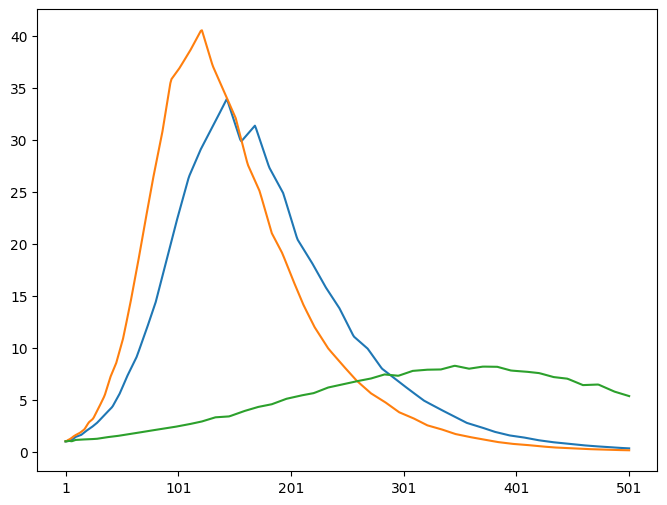

In [13]:
dfInfected.loc[1,:].plot()
dfInfected.loc[5,:].plot()
dfInfected.loc[9,:].plot()

We define a 90% / 10% of data for training / testing.

In [14]:
dfInfected_arr = dfInfected.values
dfInfected_arr.shape
TRAIN_SPLIT = int(dfInfected_arr.shape[0]-dfInfected_arr.shape[0]*0.1)
TRAIN_SPLIT

135

We standardize the data.

In [15]:
uni_train_mean = dfInfected_arr[:TRAIN_SPLIT].mean()
uni_train_std = dfInfected_arr[:TRAIN_SPLIT].std()
uni_data = (dfInfected_arr-uni_train_mean)/uni_train_std
print ('\n Univariate data shape')
print(uni_data.shape)


 Univariate data shape
(150, 501)


We split the data into time series of `univariate_past_history=20` days length and predict the future of the current day, i.e., `univariate_future_target=0`, for the "infected" variable. 

In [16]:
def univariate_data(dataset, start_series, end_series, history_size, target_size):
    data = []
    labels = []
    start_index = history_size
    end_index = len(dataset[0]) - target_size   
    for c in range(start_series, end_series):
        for i in range(start_index, end_index):
            indices = range(i-history_size, i)
            # Reshape data from (history_size,) to (history_size, 1)
            data.append(np.reshape(dataset[c][indices], (history_size, 1)))
            labels.append(dataset[c][i+target_size])
    return np.array(data), np.array(labels)

In [ ]:
univariate_past_history = 20 #days
univariate_future_target = 0 #current day

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, len(uni_data),
                                       univariate_past_history,
                                       univariate_future_target)

In [18]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target number to predict')
print (y_train_uni[0])
print ('\n Number of traing data points')
print (y_train_uni.shape[0])
print ('\n Number of test data points')
print (x_val_uni.shape[0])

Single window of past history
[[-0.95291296]
 [-0.95044298]
 [-0.94499366]
 [-0.9402021 ]
 [-0.93751136]
 [-0.93827393]
 [-0.93332191]
 [-0.92398652]
 [-0.91523643]
 [-0.90667772]
 [-0.90243571]
 [-0.89846308]
 [-0.89449045]
 [-0.89051782]
 [-0.88593997]
 [-0.87701137]
 [-0.86808277]
 [-0.85915417]
 [-0.85022557]
 [-0.84167481]]

 Target number to predict
-0.8339932964893617

 Number of traing data points
64935

 Number of test data points
7215


In [19]:
def create_time_steps(length):
    return list(range(-length, 0))

In [20]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\kemal\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\\matplotlib\\pyplot.py'>

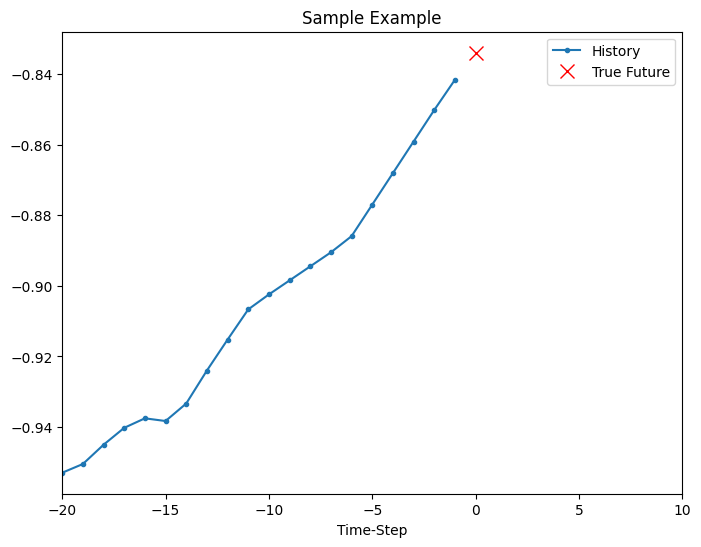

In [21]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

## Baseline forecasting

Predicts the mean of the `history`.

In [22]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from 'C:\\Users\\kemal\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\\matplotlib\\pyplot.py'>

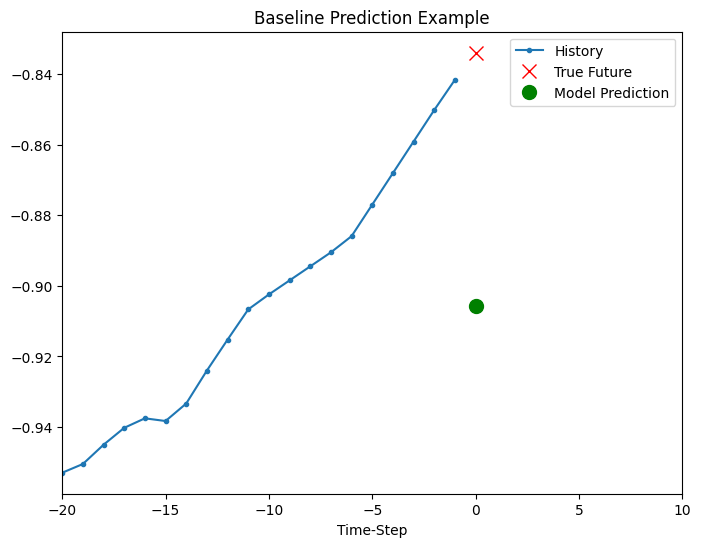

In [23]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Baseline Prediction Example')

## Univariate LSTM based forecasting

In [24]:
print (x_train_uni.shape)
print (y_train_uni.shape)
x_train_uni.dtype

(64935, 20, 1)
(64935,)


dtype('float64')

Batching and resampling; the dataset is repeated indefinitely. Check the tutorial for the details.

In [25]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

train_univariate

<_RepeatDataset element_spec=(TensorSpec(shape=(None, 20, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

We define the first LSTM model with 8 units.

In [26]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')
simple_lstm_model.summary()
x_train_uni.shape[-2:]

C:\Users\kemal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 8)              │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329 (1.29 KB)

 Trainable params: 329 (1.29 KB)

 Non-trainable params: 0 (0.00 B)

(20, 1)

In [27]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)
    print(y.shape)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
(256, 1)
(256,)


When passing an indefinitely repeated training data set, we need to specify the numbre of steps per training interval (epoch).

In [28]:
EVALUATION_INTERVAL = 2000
EPOCHS = 10

simple_lstm_model.fit(train_univariate, 
                      epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, 
                      validation_steps=50)

Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0494 - val_loss: 0.0042
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.0039 - val_loss: 0.0023
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 9/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 10/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.0016 - val_loss: 0.0013


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


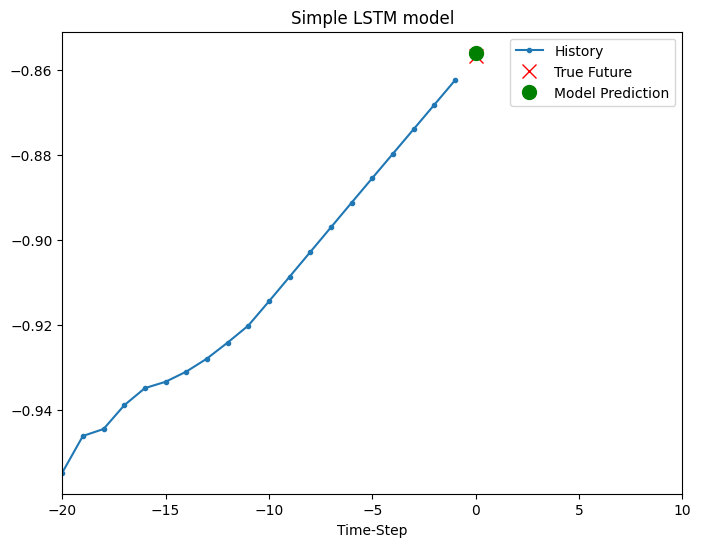

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


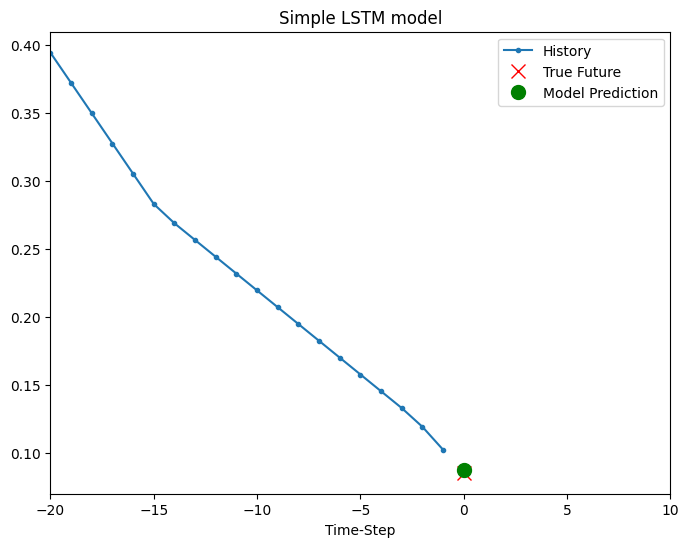

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


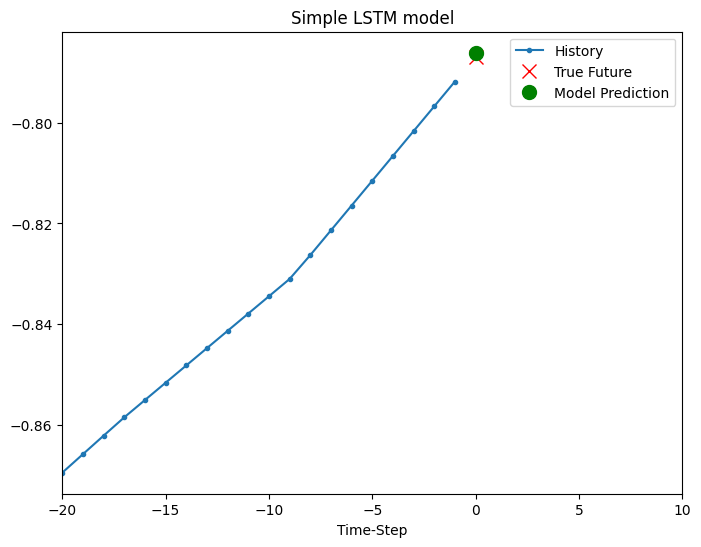

In [29]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(), simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

## Multivariate LSTM based forecasting - Single Step

We use three variables "Infected", "Recovered", and "Deceased", to forcast "Infected" at one single day in the future.

Here a plot of the time series of the three variables for one outbreak. 

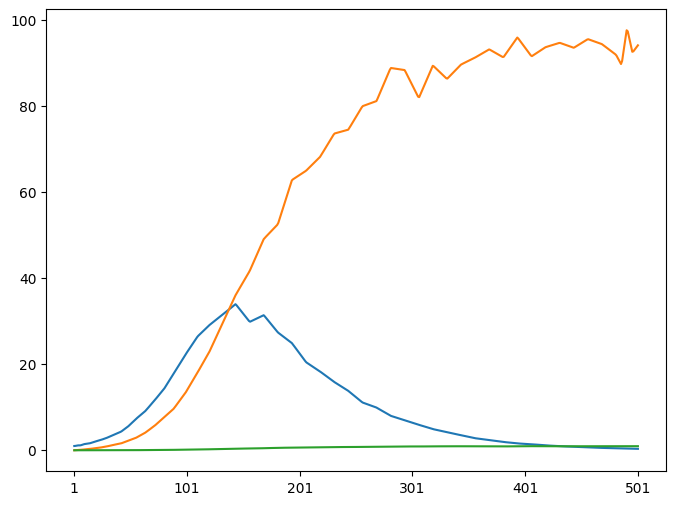

In [30]:
dfInfected.loc[1,:].plot()
dfRecovered.loc[2,:].plot()
dfDead.loc[3,:].plot()
dfInfected = dfInfected.values
dfRecovered_arr = dfRecovered.values
dfDead_arr = dfDead.values

We prepare the dataset.

In [31]:
#as before
dfInfected_train_mean = dfInfected_arr[:TRAIN_SPLIT].mean()
dfInfected_train_std = dfInfected_arr[:TRAIN_SPLIT].std()
dfInfected_data = (dfInfected_arr-dfInfected_train_mean)/dfInfected_train_std
#for Recovered
dfRecovered_train_mean = dfRecovered_arr[:TRAIN_SPLIT].mean()
dfRecovered_train_std = dfRecovered_arr[:TRAIN_SPLIT].std()
dfRecovered_data = (dfRecovered_arr-dfRecovered_train_mean)/dfRecovered_train_std
#for Dead
dfDead_train_mean = dfDead_arr[:TRAIN_SPLIT].mean()
dfDead_train_std = dfDead_arr[:TRAIN_SPLIT].std()
dfDead_data = (dfDead_arr-dfDead_train_mean)/dfDead_train_std

In [32]:
dataset = np.array([dfInfected_data, dfRecovered_data, dfDead_data])
dataset.shape
print ('\n Multivariate data shape')
print(dataset.shape)


 Multivariate data shape
(3, 150, 501)


In [33]:
def multivariate_data(dataset, target, start_series, end_series, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []
    start_index = history_size
    end_index = len(dataset[0][0]) - target_size   
    for c in range(start_series, end_series):
        for i in range(start_index, end_index):
            indices = range(i-history_size, i, step)
            one = dataset[0][c][indices]
            two = dataset[1][c][indices]
            three = dataset[2][c][indices]
            data.append(np.transpose(np.array([one, two, three])))
            
            if single_step:
                labels.append(target[c][i+target_size])
            else:
                labels.append(np.transpose(target[c][i:i+target_size]))
    return np.array(data), np.array(labels)

We get training and valdation data for time series with a `past_history = 20` days for every other day (`STEP = 2`) and want to predict the "Infected" five days ahead (`future_target = 5`).

In [34]:
past_history = 20
future_target = 5
STEP = 2

x_train_single, y_train_single = multivariate_data(dataset, dfInfected_data, 0, TRAIN_SPLIT, 
                                                   past_history, future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dfInfected_data, TRAIN_SPLIT, dataset.shape[1], 
                                               past_history, future_target, STEP,
                                               single_step=True)

In [35]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))
print(dataset.shape)

Single window of past history : (10, 3)
(3, 150, 501)


As before, batching and resampling; the dataset is repeated indefinitely.

In [36]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [37]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
single_step_model.summary()
x_train_single.shape[-2:]

C:\Users\kemal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 32)             │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,641 (18.13 KB)

 Trainable params: 4,641 (18.13 KB)

 Non-trainable params: 0 (0.00 B)

(10, 3)

In [38]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)
print ('\n Number of traing data points')
print (x_train_single.shape[0])
print ('\n Number of test data points')
print (x_val_single.shape[0])

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
(256, 1)

 Number of traing data points
64260

 Number of test data points
7140


In [39]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 0.0806 - val_loss: 0.0284
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.0265 - val_loss: 0.0200
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.0225 - val_loss: 0.0175
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.0202 - val_loss: 0.0170
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.0186 - val_loss: 0.0167
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.0175 - val_loss: 0.0142
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 0.0167 - val_loss: 0.0148
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 0.0161 - val_loss: 0.0142
Epoch 9/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 0.0156 - val_loss: 0.0131
Epoch 10/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 0.0152 - val_loss: 0.0127


In [40]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.show()

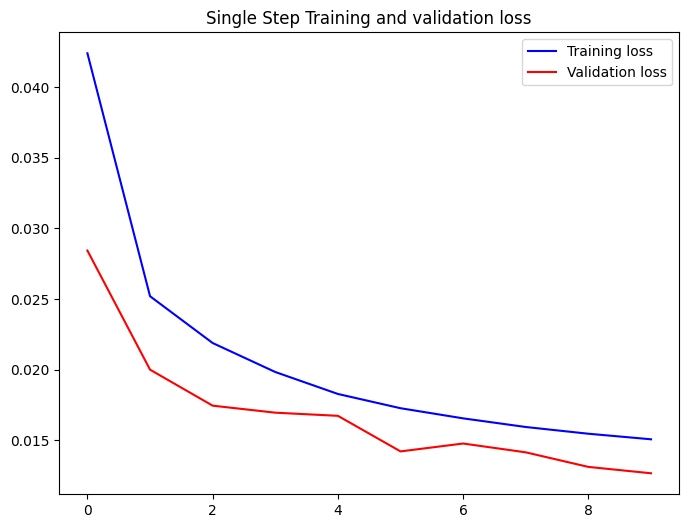

In [41]:
plot_train_history(single_step_history,'Single Step Training and validation loss')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


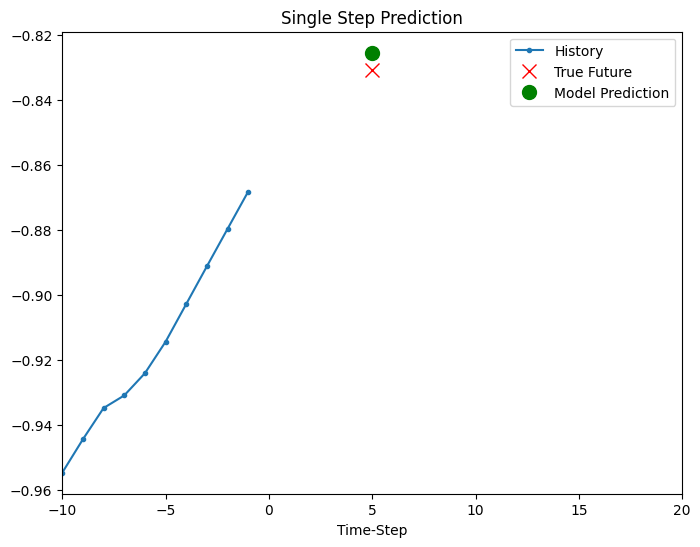

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


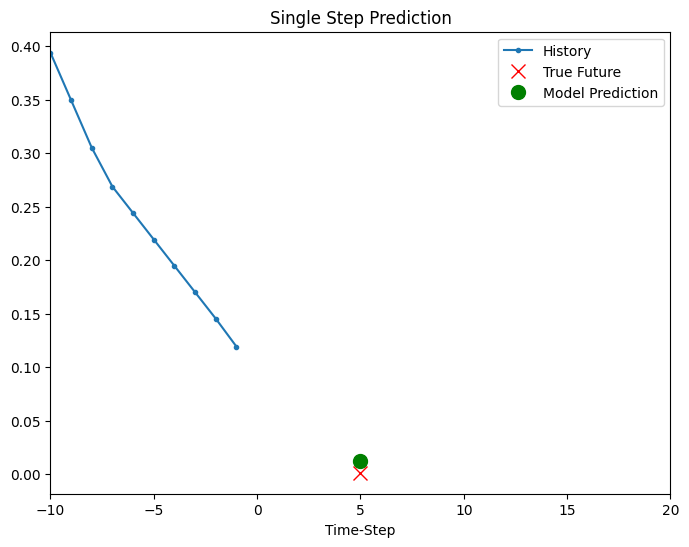

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


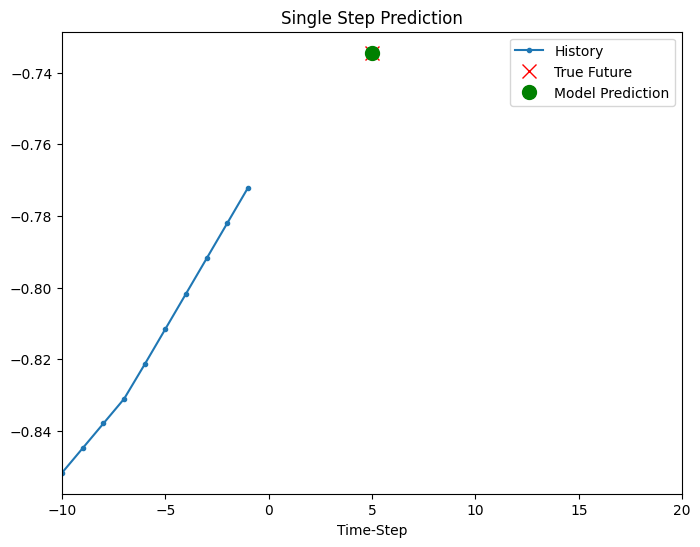

In [42]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], future_target,
                   'Single Step Prediction')
    plot.show()

## Multivariate LSTM - Multiple Steps

Still, we use a series of observed values of the three variables "Infected", "Recovered", and "Deceased" (`past_history = 40, STEP =2`), but now to forcast the "Infected" values for a series day in the future (`future_target = 10`).

In [43]:
past_history = 40
future_target = 10
STEP =2
x_train_multi, y_train_multi = multivariate_data(dataset, dfInfected_data, 0, TRAIN_SPLIT, 
                                                    past_history, future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dfInfected_data, TRAIN_SPLIT, dataset.shape[1], 
                                                past_history, future_target, STEP)

In [44]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\nTarget window to predict : {}'.format(y_train_multi[0].shape))
print ('\nNumber of traing data points: {}'.format(x_train_multi.shape[0]))
print ('\nNumber of test data points: {}'.format(x_val_multi.shape[0]))

Single window of past history : (20, 3)

Target window to predict : (10,)

Number of traing data points: 60885

Number of test data points: 6765


As before, batching and resampling; the dataset is repeated indefinitely.

In [45]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [46]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    plt.plot(num_in, np.array(history[:, 0]), label='History')
    plt.plot(np.arange(num_out), np.array(true_future), 'bo', label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out), np.array(prediction), 'ro', label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

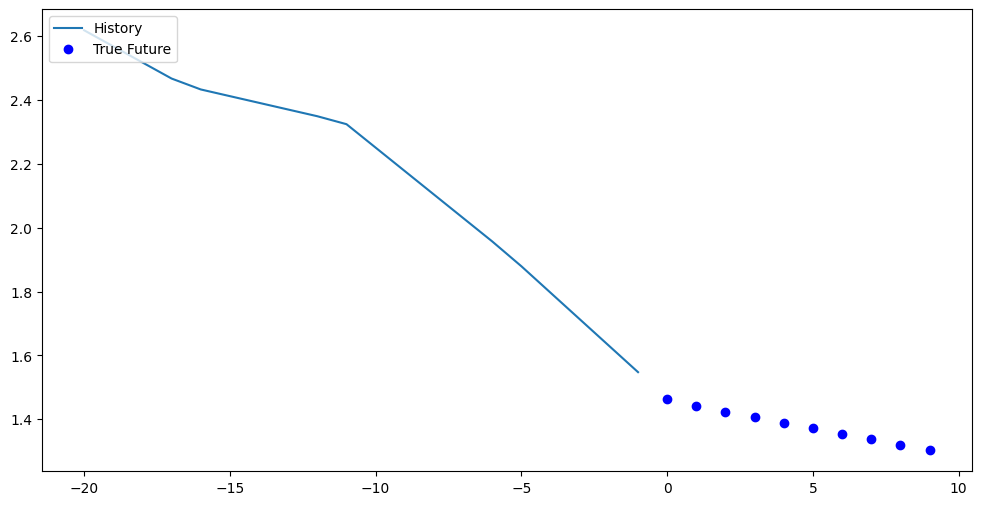

In [47]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

Now we bild a model with two LSTM layers.

In [48]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future_target))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
multi_step_model.summary()
x_train_multi.shape[-2:]

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 20, 32)         │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,914 (30.91 KB)

 Trainable params: 7,914 (30.91 KB)

 Non-trainable params: 0 (0.00 B)

(20, 3)

In [49]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
(256, 10)


The training time is longer for this more complex model.

In [50]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 45s 21ms/step - loss: 0.1520 - val_loss: 0.0366
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 43s 22ms/step - loss: 0.0367 - val_loss: 0.0224
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 43s 22ms/step - loss: 0.0303 - val_loss: 0.0261
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - loss: 0.0266 - val_loss: 0.0243
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 47s 23ms/step - loss: 0.0237 - val_loss: 0.0186
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - loss: 0.0217 - val_loss: 0.0154
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - loss: 0.0202 - val_loss: 0.0164
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - loss: 0.0190 - val_loss: 0.0179
Epoch 9/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 38s 19ms/step - loss: 0.0183 - val_loss: 0.0155
Epoch 10/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 35s 18ms/step - loss: 0.0177 - val_loss: 0.0155


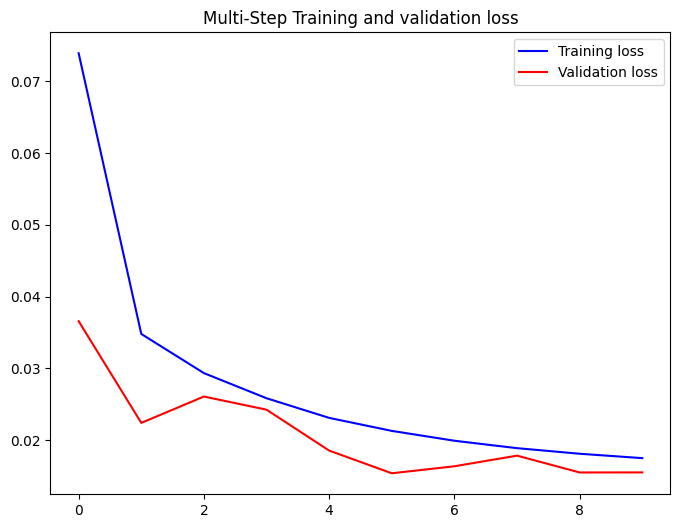

In [51]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


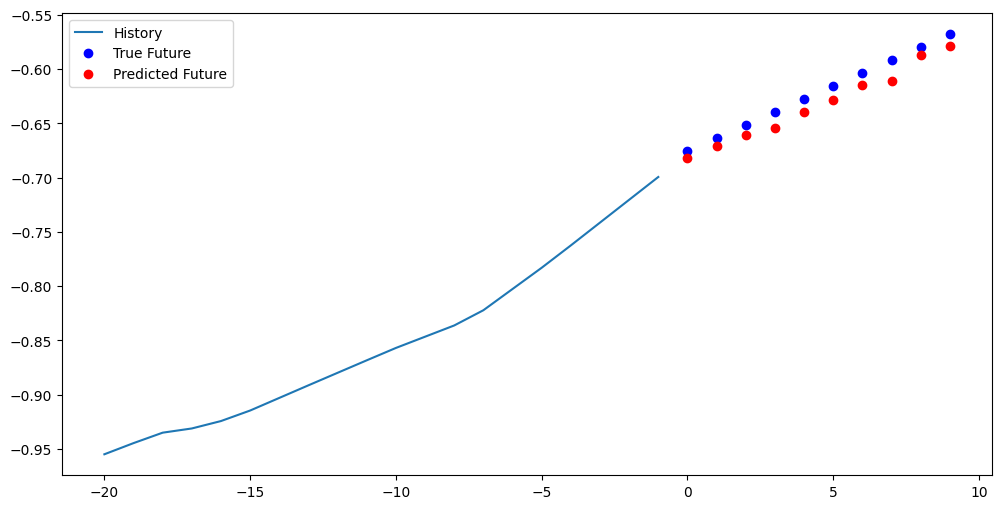

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


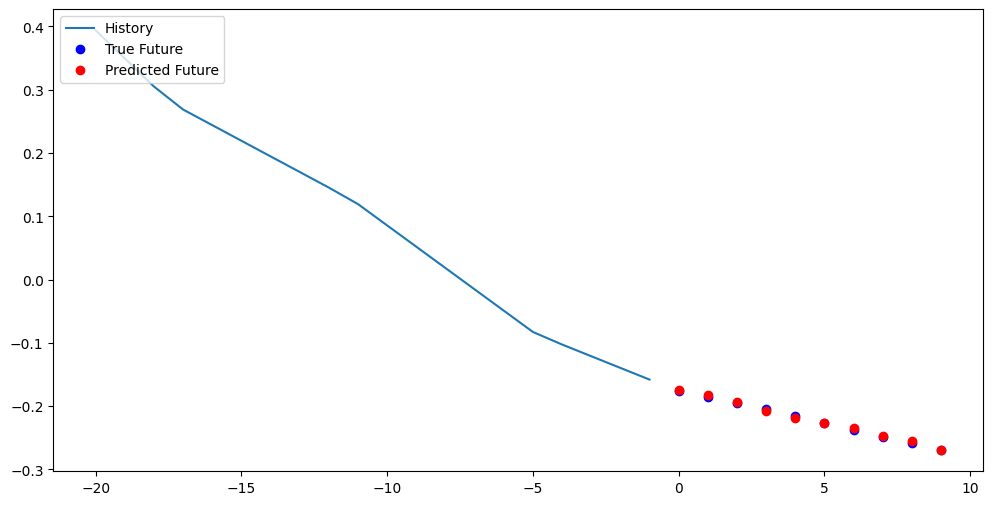

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


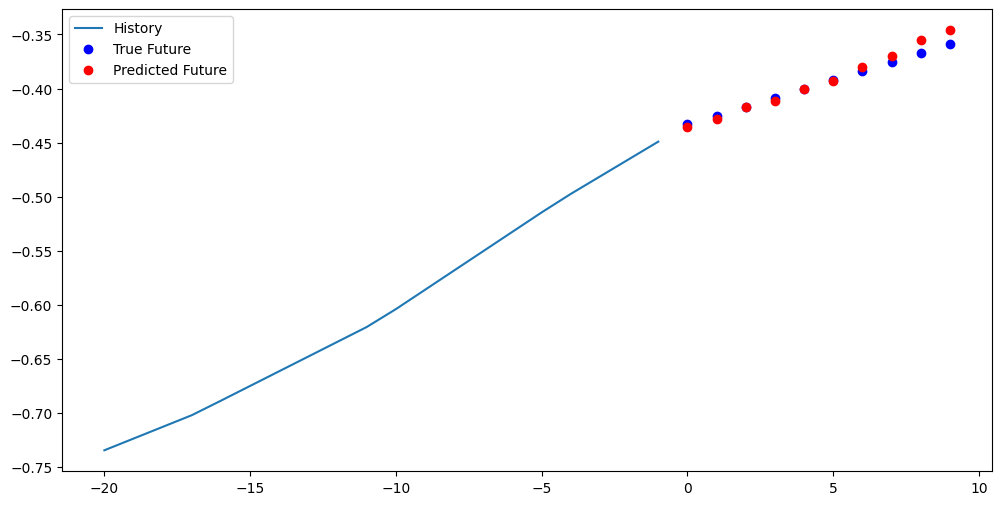

In [52]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

___________________________________________________________________________________________

# MODIEFIED MODELS

In this chapter, i have made modifications to the code featured in the previous chapters. What i did is that i copied over chapters 4, 5 and 6 and collapsed them together so that they would have their own notebook cell in this chapter. This was done to make the changes easier to highlight and understand even though the notebook might be less "modular".

Below, you will find every change that i made. A lot of them were already suggested in the Moodle page but some of them were also made solely by me as i found some small opportunities to change the model and the outcome of the model.

A lot of the conclusions that i make from my experiments are visual. This means that i try to compare the accuracy from my graphs and logs to the already provided models and try to draw conclusions from that instead of tracking some kind of metric as that might not tell us the full story of how the model performs over epochs. the logs will instead give me a clearer picture.

- SWAPPING FROM LSTM TO GRU

    The first thing i did was to try and change the layers from LSTM to GRU. This was very simple as i could just change which `tf` function we call when defining the `simple_GRU_model`. We change the initial layer from `tf.keras.layers.LSTM` to `tf.keras.layers.GRU`. By looking at the logs from TensorFlow we can see that the amount of decreased from 320 to 264 for the simple model But i could not see clear difference in how the model performed in the logs. However, i felt that because we have quite a significant lesser amount of parameters with arguably the same performance, i sticked with GRU layer instead of LSTM as this gives us improvements on model complexity and training time.

- ADDING MORE DENSE LAYERS

    The second thing i did was to try and add ReLu-activated dense layers after the initial GRU layer. My assumption was that additional non-linear transformations could help the model capture more complex temporal patterns in the data. This was almost as easy as the previous step. The only thing i had to do was to add `tf.keras.layers.Dense(16, activation='relu'),` right below where i defined my GRU layer. I experimented with different activation functions and different amounts of units. What i in the end found was that ReLu worked quite well and by doing visual inspection i could see that having two layers with 16 and 8 units respectively gave a bit better accuracy as we were making better predictions on the true future point. Even though adding more dense layers increased the amount of parameters, as seen by the TensorFlow logs, this is in my opinion a worthy trade-off because we could still consider this model "lightweight" as it can still be trained on my consumer based laptop on CPU while getting quite a nice accuracy and performance boost overall from it.

- INCREASING HISTORY LENGTH

    I also tried increasing the history length. This was probably the easiest modification to make (not that the other ones were especially hard) because i only needed to change the `univariate_past_history` variable that was defined higher up in the code. I pasted that code over to this section of the notebook as well so that i have easier control over it. By default, it was set to 20 but i could change this to any valid int-value. First, i wanted to make a visual validation that this would make a difference so i first decreased it to 3 and got very bad results but the training time went from 2m30s to 45s for the simple model. This kind of behavior was expected so i decided to increase the variable. First i tried just doubling it from the default so i defined it as 40 days and the model convergence was much slower but we got much better results in the accuracy. This far, this is the factor that has made the biggest difference in performance which makes sence because increasing the history would give the model more context to make better future predictions.


### Univariate GRU based forecasting

(67365, 2, 1)
(67365,)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_25 (GRU)                    │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 553 (2.16 KB)

 Trainable params: 553 (2.16 KB)

 Non-trainable params: 0 (0.00 B)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
(256, 1)
(256,)
Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.1559 - val_loss: 0.0133
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0119 - val_loss: 0.0040
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 9/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 10/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0024 - val_loss: 0.0015
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


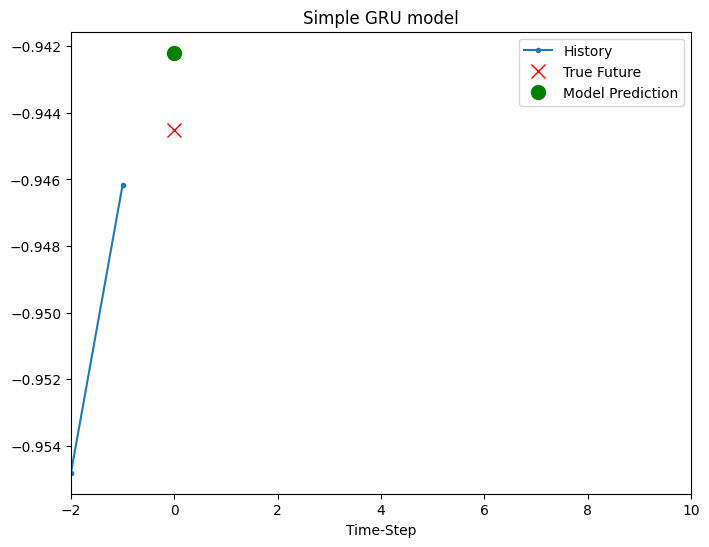

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


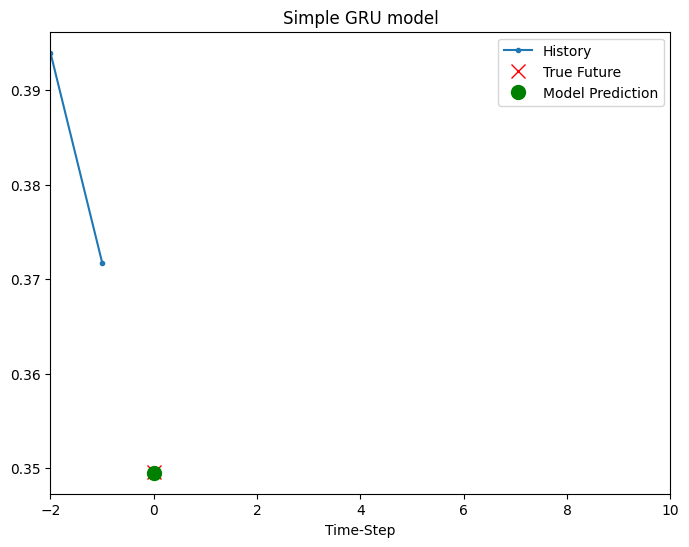

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


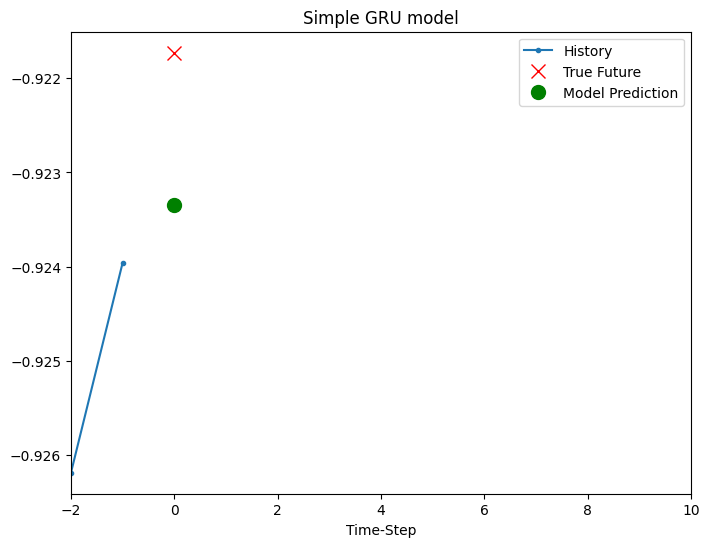

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


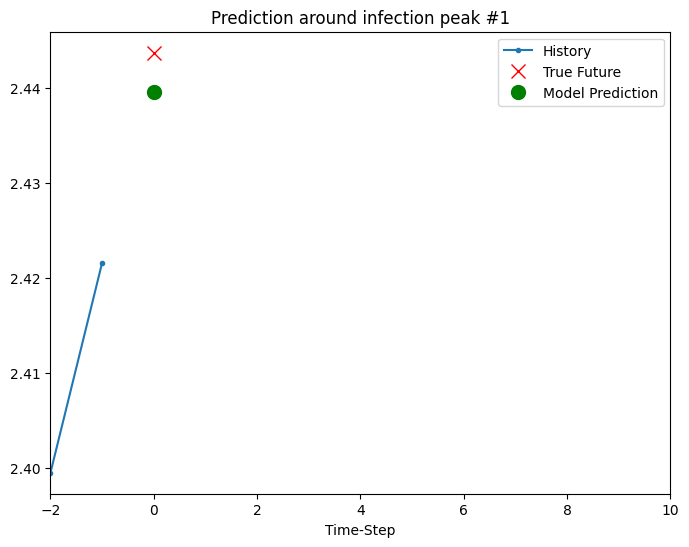

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


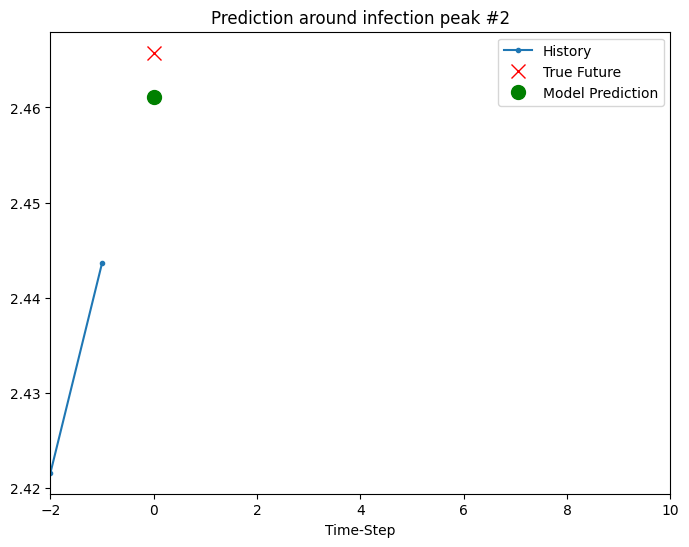

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


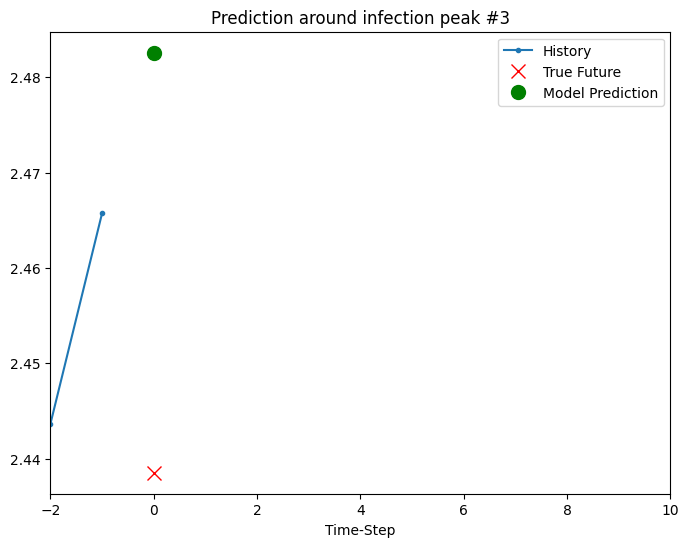

In [85]:
univariate_past_history = 2 #days
univariate_future_target = 0 #current day

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, len(uni_data),
                                       univariate_past_history,
                                       univariate_future_target)

print (x_train_uni.shape)
print (y_train_uni.shape)
x_train_uni.dtype

BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

train_univariate


# defining the model using RU instead of LSTM
simple_GRU_model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1)
])

simple_GRU_model.compile(optimizer='adam', loss='mae')
simple_GRU_model.summary()
x_train_uni.shape[-2:]

for x, y in val_univariate.take(1):
    print(simple_GRU_model.predict(x).shape)
    print(y.shape)


EVALUATION_INTERVAL = 2000
EPOCHS = 10

simple_GRU_model.fit(train_univariate, 
                      epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, 
                      validation_steps=50)

for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(), simple_GRU_model.predict(x)[0]], 0, 'Simple GRU model')
    plot.show()


# “Show diagrams with predictions around the peak of infection”

# Flatten
flat_data = uni_data[0]

# Get top 3 peak indices (excluding the very start to allow for history)
peak_indices = np.argpartition(flat_data[univariate_past_history:], -3)[-3:] + univariate_past_history
peak_indices = sorted(peak_indices)

for i, peak_idx in enumerate(peak_indices):
    start_idx = peak_idx - univariate_past_history
    input_seq = flat_data[start_idx:peak_idx].reshape(1, -1, 1)
    
    # Predict the value at the peak using your model
    predicted = simple_GRU_model.predict(input_seq)[0]
    true_value = flat_data[peak_idx]

    # Use your existing show_plot function
    plot = show_plot([input_seq[0], true_value, predicted], 0, f'Prediction around infection peak #{i+1}')
    plot.show()

### Multivariate GRU based forecasting - Single Step


 Multivariate data shape
(3, 150, 501)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_27 (GRU)                    │ (None, 32)             │         3,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,585 (14.00 KB)

 Trainable params: 3,585 (14.00 KB)

 Non-trainable params: 0 (0.00 B)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
(256, 1)

 Number of traing data points
66690

 Number of test data points
7410
Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1124 - val_loss: 0.0232
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0264 - val_loss: 0.0262
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0248 - val_loss: 0.0207
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0240 - val_loss: 0.0198
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0232 - val_loss: 0.0211
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0228 - val_loss: 0.0210
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0228 - val_loss: 0.0187
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0223 - val_loss: 0.0211
Epoch 9/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0221 - val_loss: 0.0203
Epoch 10/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0221 - val_loss: 0.0202


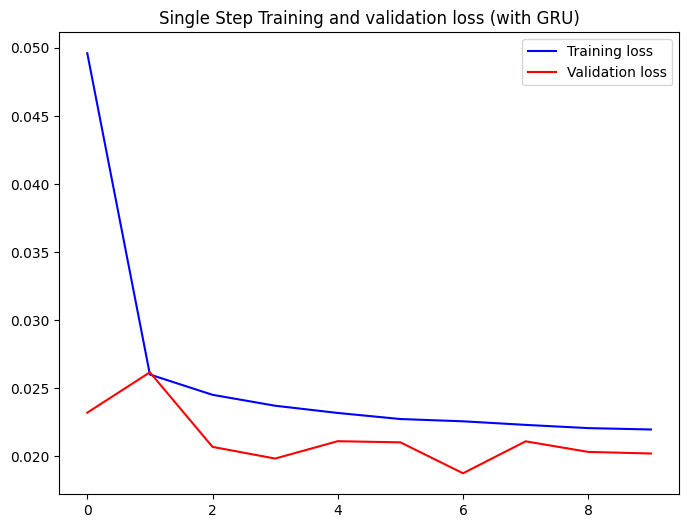

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


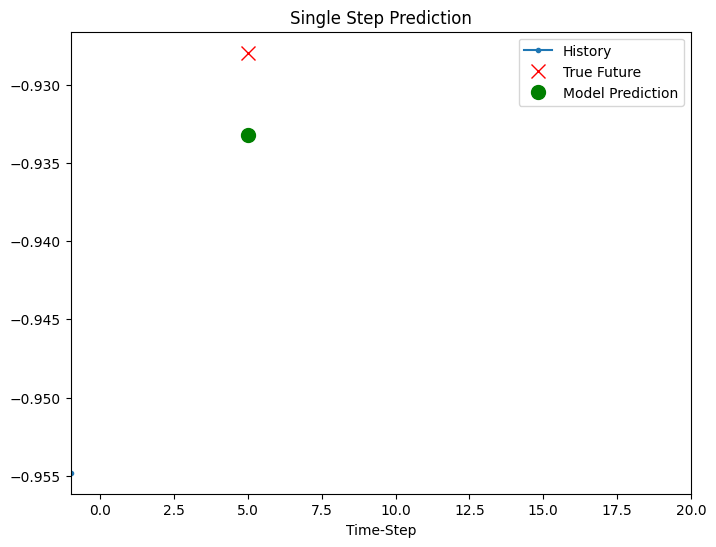

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


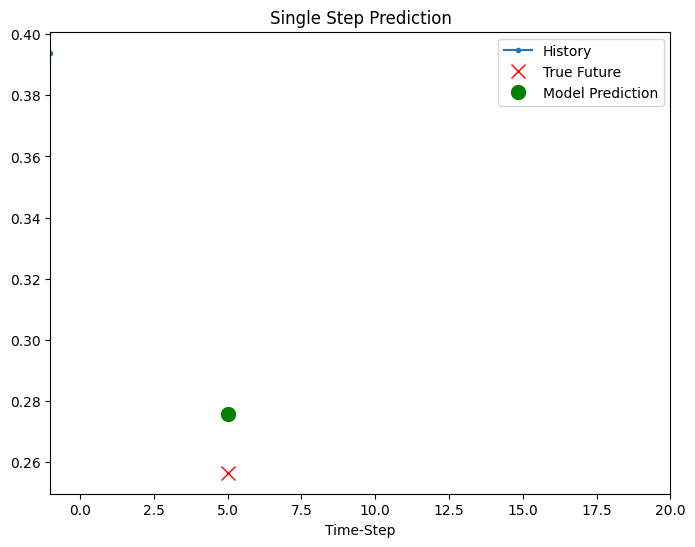

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


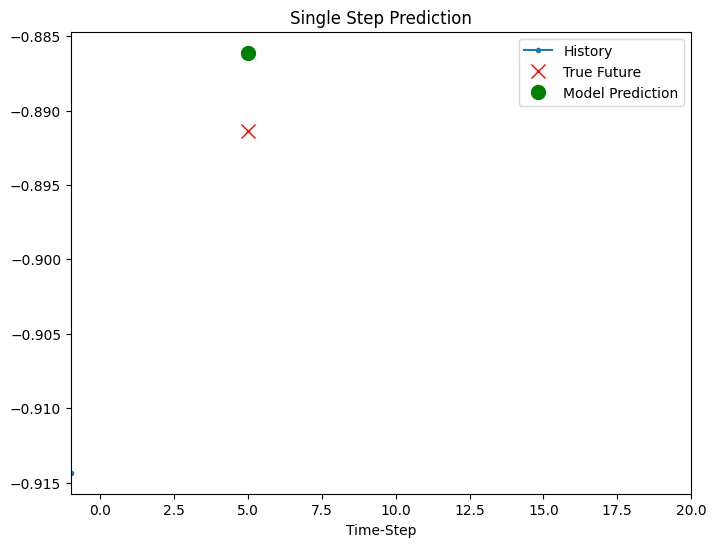

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Peak #1 — Index: 142, True: 2.444, Predicted: 2.391


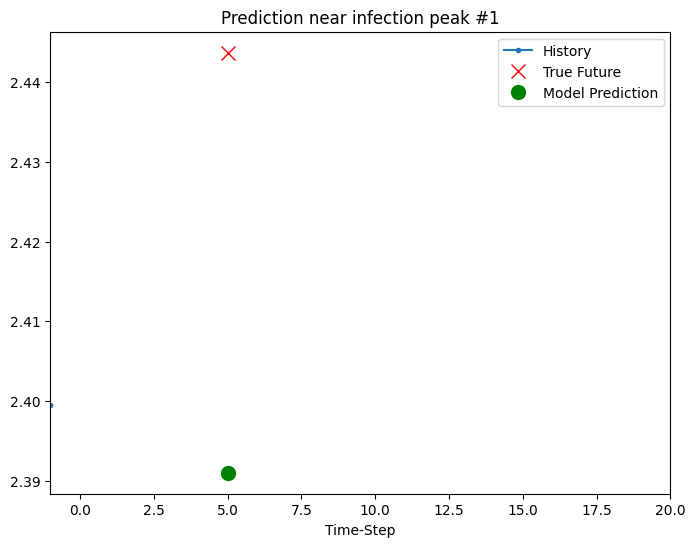

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Peak #2 — Index: 143, True: 2.466, Predicted: 2.403


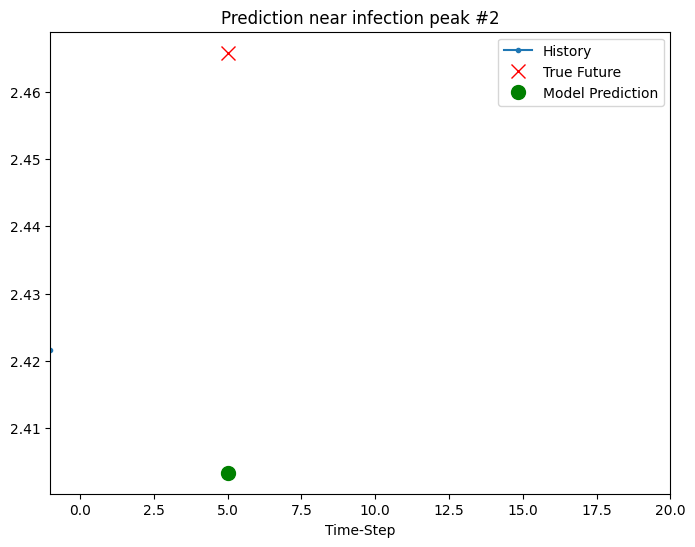

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Peak #3 — Index: 144, True: 2.439, Predicted: 2.416


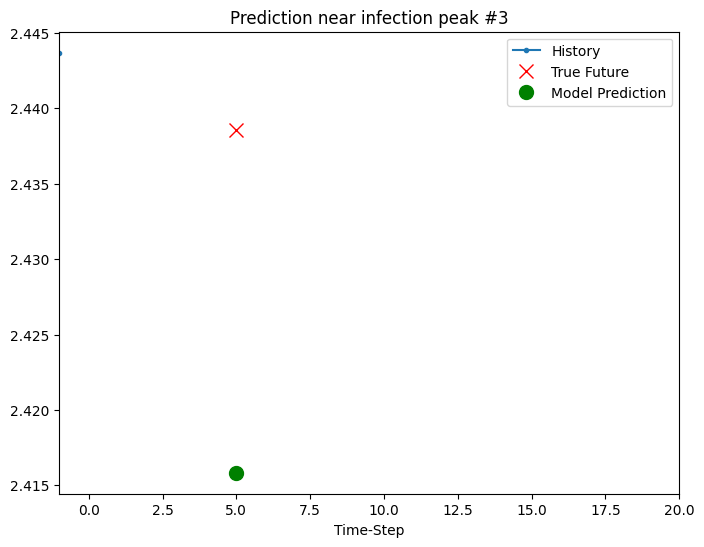

In [87]:
#as before
dfInfected_train_mean = dfInfected_arr[:TRAIN_SPLIT].mean()
dfInfected_train_std = dfInfected_arr[:TRAIN_SPLIT].std()
dfInfected_data = (dfInfected_arr-dfInfected_train_mean)/dfInfected_train_std
#for Recovered
dfRecovered_train_mean = dfRecovered_arr[:TRAIN_SPLIT].mean()
dfRecovered_train_std = dfRecovered_arr[:TRAIN_SPLIT].std()
dfRecovered_data = (dfRecovered_arr-dfRecovered_train_mean)/dfRecovered_train_std
#for Dead
dfDead_train_mean = dfDead_arr[:TRAIN_SPLIT].mean()
dfDead_train_std = dfDead_arr[:TRAIN_SPLIT].std()
dfDead_data = (dfDead_arr-dfDead_train_mean)/dfDead_train_std

dataset = np.array([dfInfected_data, dfRecovered_data, dfDead_data])
dataset.shape
print ('\n Multivariate data shape')
print(dataset.shape)

def multivariate_data(dataset, target, start_series, end_series, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []
    start_index = history_size
    end_index = len(dataset[0][0]) - target_size   
    for c in range(start_series, end_series):
        for i in range(start_index, end_index):
            indices = range(i-history_size, i, step)
            one = dataset[0][c][indices]
            two = dataset[1][c][indices]
            three = dataset[2][c][indices]
            data.append(np.transpose(np.array([one, two, three])))
            
            if single_step:
                labels.append(target[c][i+target_size])
            else:
                labels.append(np.transpose(target[c][i:i+target_size]))
    return np.array(data), np.array(labels)

past_history = 2
future_target = 5
STEP = 2

x_train_single, y_train_single = multivariate_data(dataset, dfInfected_data, 0, TRAIN_SPLIT, 
                                                   past_history, future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dfInfected_data, TRAIN_SPLIT, dataset.shape[1], 
                                               past_history, future_target, STEP,
                                               single_step=True)

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

single_step_model_GRU = tf.keras.models.Sequential()
single_step_model_GRU.add(tf.keras.layers.GRU(32, input_shape=x_train_single.shape[-2:]))
single_step_model_GRU.add(tf.keras.layers.Dense(1))

single_step_model_GRU.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')
single_step_model_GRU.summary()
x_train_single.shape[-2:]

for x, y in val_data_single.take(1):
    print(single_step_model_GRU.predict(x).shape)
print ('\n Number of traing data points')
print (x_train_single.shape[0])
print ('\n Number of test data points')
print (x_val_single.shape[0])


single_step_history_GRU = single_step_model_GRU.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.show()

plot_train_history(single_step_history_GRU,'Single Step Training and validation loss (with GRU)')

for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                    single_step_model_GRU.predict(x)[0]], future_target,
                   'Single Step Prediction')
    plot.show()

# “Show diagrams with predictions around the peak of infection”

# Use standardized infection data for peak detection
flat_data = dfInfected_data[0] if len(dfInfected_data.shape) == 2 else dfInfected_data

# Identify top 3 peaks (exclude early points to leave room for history)
peak_indices = np.argpartition(flat_data[past_history:], -3)[-3:] + past_history
peak_indices = sorted(peak_indices)

for i, peak_idx in enumerate(peak_indices):
    # Get indices with correct step size
    input_indices = range(peak_idx - past_history, peak_idx, STEP)
    one = dfInfected_data[0][input_indices]
    two = dfRecovered_data[0][input_indices]
    three = dfDead_data[0][input_indices]

    input_seq = np.transpose(np.array([one, two, three])).reshape(1, -1, 3)

    # Predict future value using multivariate GRU model
    predicted = single_step_model_GRU.predict(input_seq)[0]
    true_value = dfInfected_data[0][peak_idx]

    print(f"Peak #{i+1} — Index: {peak_idx}, True: {true_value:.3f}, Predicted: {predicted[0]:.3f}")

    # Use your custom plot function (adapted for multivariate input)
    plot = show_plot([input_seq[0][:, 0], true_value, predicted], future_target,
                     f'Prediction near infection peak #{i+1}')
    plot.show()

### Multivariate GRU - Multiple Steps

Single window of past history : (1, 3)

Target window to predict : (10,)

Number of traing data points: 66015

Number of test data points: 7335


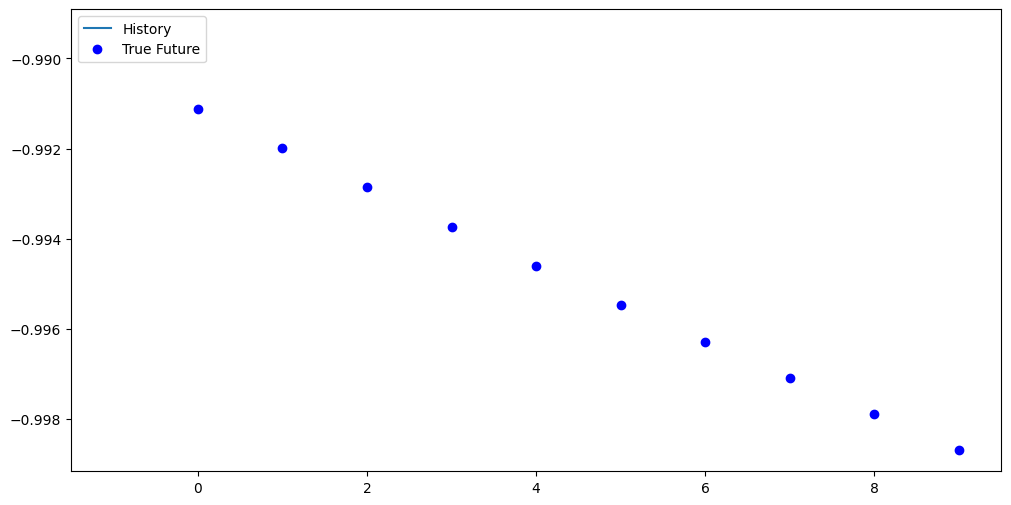

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_28 (GRU)                    │ (None, 1, 32)          │         3,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_29 (GRU)                    │ (None, 16)             │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,122 (23.91 KB)

 Trainable params: 6,122 (23.91 KB)

 Non-trainable params: 0 (0.00 B)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
(256, 10)
Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.1971 - val_loss: 0.0242
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0255 - val_loss: 0.0212
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0236 - val_loss: 0.0200
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0224 - val_loss: 0.0222
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0217 - val_loss: 0.0186
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0211 - val_loss: 0.0185
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0208 - val_loss: 0.0184
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0204 - val_loss: 0.0160
Epoch 9/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0203 - val_loss: 0.0191
Epoch 10/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0200 - val_loss: 0.0187


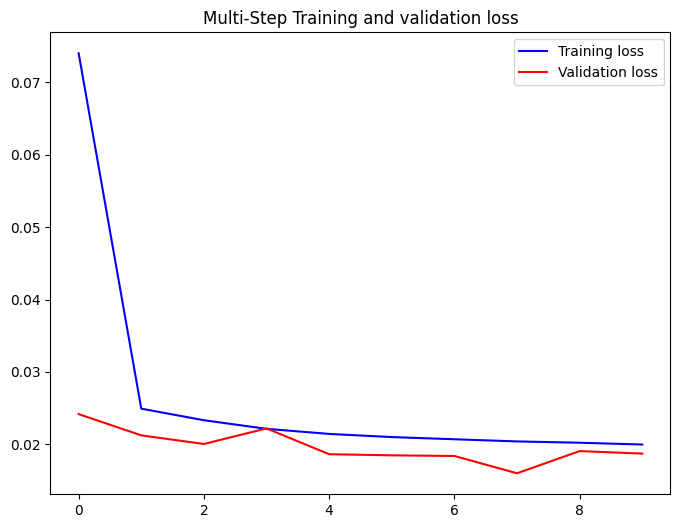

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


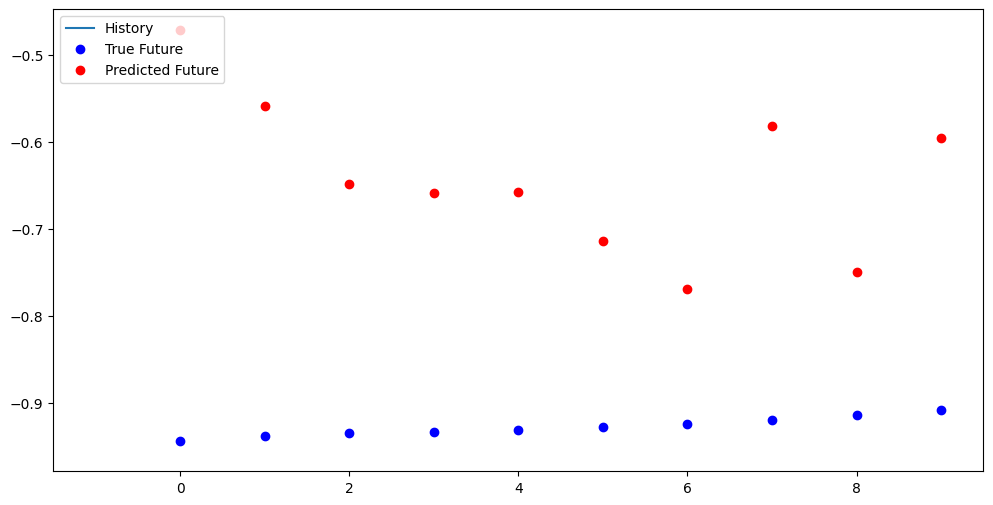

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


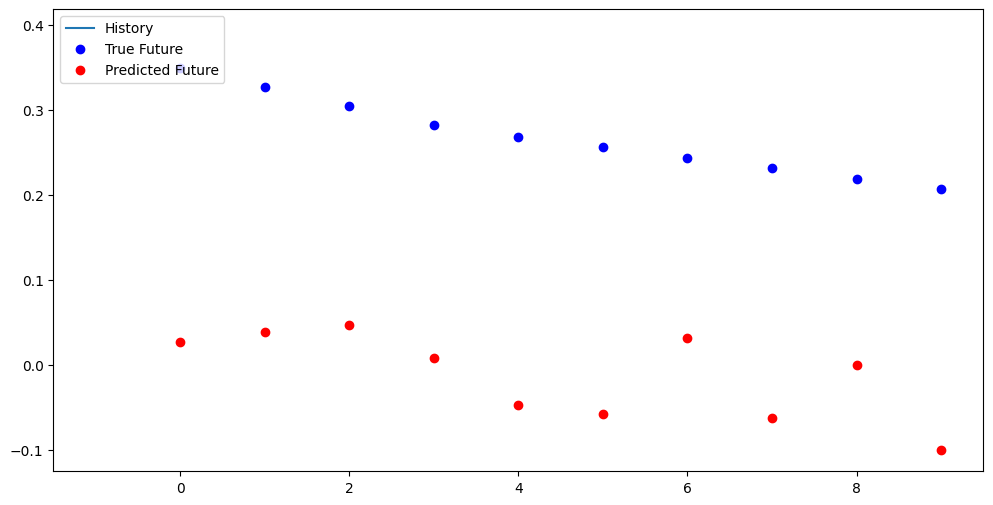

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


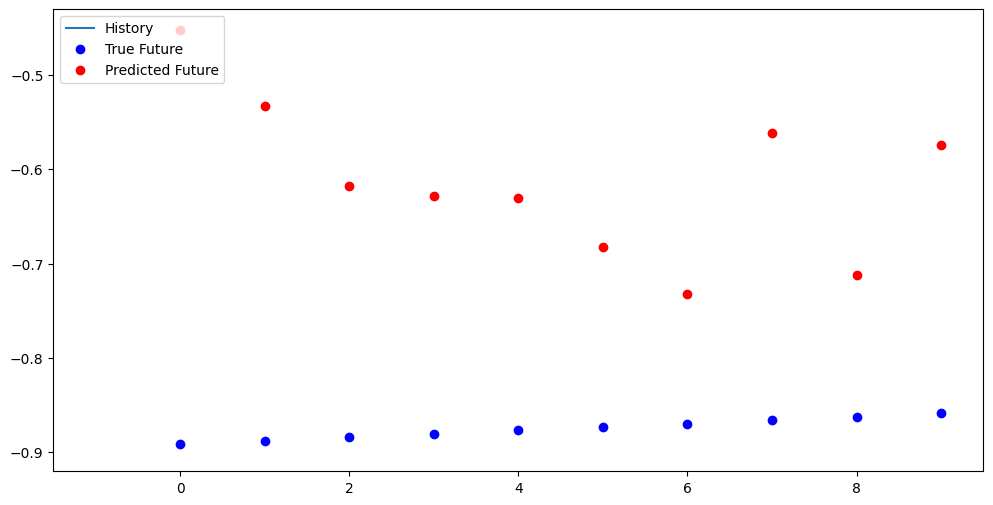

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
Peak #1 — index: 142
True future: [2.44368116 2.46575886 2.43853705 2.40422225 2.36990746 2.33559267
 2.30127788 2.26696308 2.23264829 2.1983335 ]
Predicted:    [3.8172488 3.8891966 3.9488564 3.7103574 3.9021122 3.9108114 3.8921735
 3.903852  4.0883217 4.083814 ]


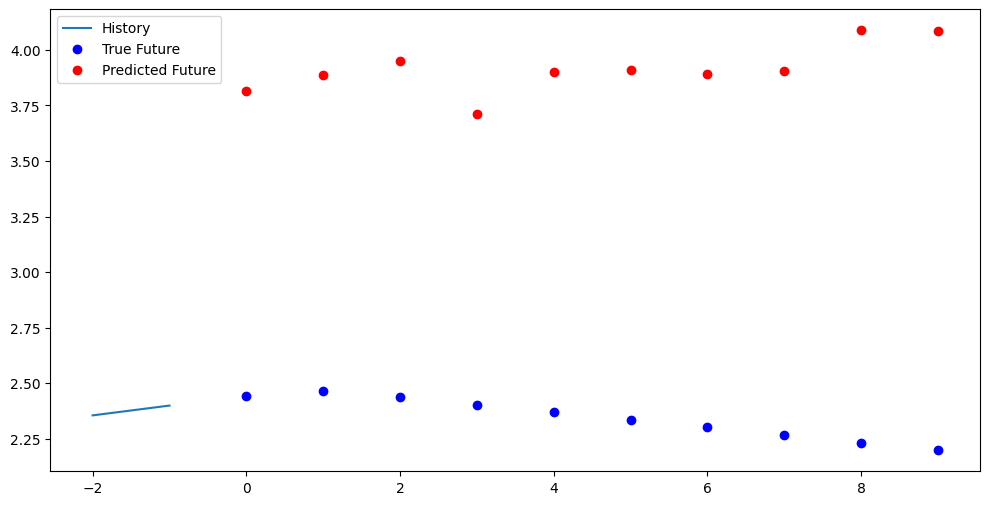

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Peak #2 — index: 143
True future: [2.46575886 2.43853705 2.40422225 2.36990746 2.33559267 2.30127788
 2.26696308 2.23264829 2.1983335  2.16401871]
Predicted:    [3.8405747 3.910125  3.969345  3.7262294 3.916149  3.9204154 3.90064
 3.9083493 4.0926685 4.083204 ]


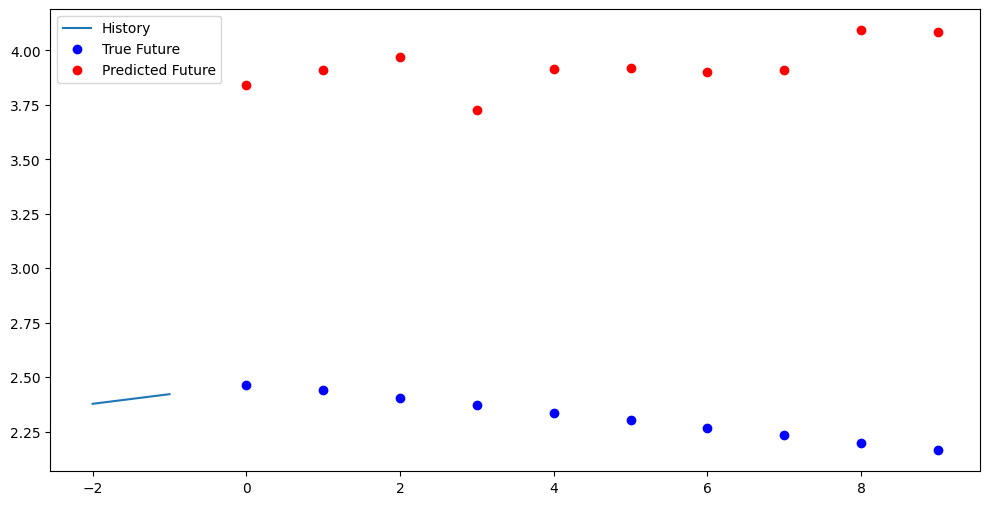

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Peak #3 — index: 144
True future: [2.43853705 2.40422225 2.36990746 2.33559267 2.30127788 2.26696308
 2.23264829 2.1983335  2.16401871 2.12970391]
Predicted:    [3.8636208 3.9308145 3.9895458 3.7418885 3.929989  3.9298353 3.9089372
 3.9126835 4.096877  4.0825   ]


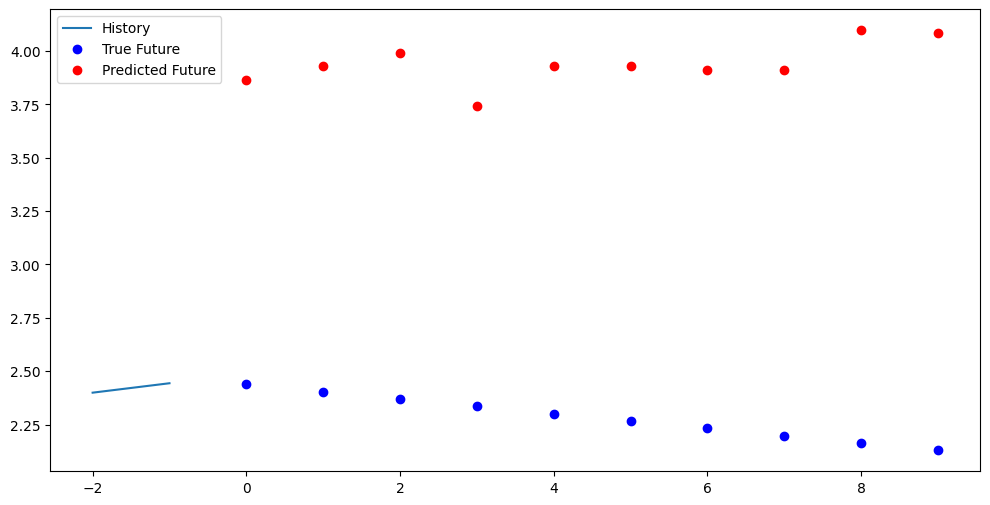

In [88]:
past_history = 2
future_target = 10
STEP =2

x_train_multi, y_train_multi = multivariate_data(dataset, dfInfected_data, 0, TRAIN_SPLIT, 
                                                    past_history, future_target, STEP)

x_val_multi, y_val_multi = multivariate_data(dataset, dfInfected_data, TRAIN_SPLIT, dataset.shape[1], 
                                                past_history, future_target, STEP)

print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\nTarget window to predict : {}'.format(y_train_multi[0].shape))
print ('\nNumber of traing data points: {}'.format(x_train_multi.shape[0]))
print ('\nNumber of test data points: {}'.format(x_val_multi.shape[0]))

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    plt.plot(num_in, np.array(history[:, 0]), label='History')
    plt.plot(np.arange(num_out), np.array(true_future), 'bo', label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out), np.array(prediction), 'ro', label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

multi_step_model_GRU = tf.keras.models.Sequential()
multi_step_model_GRU.add(tf.keras.layers.GRU(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model_GRU.add(tf.keras.layers.GRU(16, activation='relu'))
multi_step_model_GRU.add(tf.keras.layers.Dense(future_target))

multi_step_model_GRU.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
multi_step_model_GRU.summary()
x_train_multi.shape[-2:]

for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

multi_step_history_GRU = multi_step_model_GRU.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

plot_train_history(multi_step_history_GRU, 'Multi-Step Training and validation loss')

for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])



# “Show diagrams with predictions around the peak of infection”

# Use dfInfected_data for peak detection
flat_data = dfInfected_data[0] if len(dfInfected_data.shape) == 2 else dfInfected_data

# Find top 3 peak indices after enough history
peak_indices = np.argpartition(flat_data[past_history:], -3)[-3:] + past_history
peak_indices = sorted(peak_indices)

for i, peak_idx in enumerate(peak_indices):
    # Compute input indices based on history size and STEP
    input_indices = range(peak_idx - past_history * STEP, peak_idx, STEP)
    one = dfInfected_data[0][input_indices]
    two = dfRecovered_data[0][input_indices]
    three = dfDead_data[0][input_indices]

    input_seq = np.transpose(np.array([one, two, three])).reshape(1, -1, 3)

    # Predict the 10-step future
    prediction = multi_step_model_GRU.predict(input_seq)[0]
    true_future = flat_data[peak_idx:peak_idx + future_target]

    # If peak is too close to the end, skip
    if len(true_future) < future_target:
        continue

    print(f"Peak #{i+1} — index: {peak_idx}")
    print(f"True future: {true_future}")
    print(f"Predicted:    {prediction}")

    # Use your multi-step plot function
    multi_step_plot(input_seq[0], true_future, prediction)

